# Solving Max-Cut Problem with QAOA

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## Overview

In the [tutorial on Quantum Approximate Optimization Algorithm](./QAOA_EN.ipynb), we talked about how to encode a classical combinatorial optimization problem into a quantum optimization problem and slove it with Quantum Approximate Optimization Algorithm [1] (QAOA). In this tutorial, we will take the Max-Cut Problem as an example to further elaborate on QAOA.

### Max-Cut Problem

The Max-Cut Problem is a common combinatorial optimization problem in graph theory, and it has important applications in statistical physics and circuit design. The maximum cut problem is an NP-hard problem, so there is no efficient algorithm that can solve this problem perfectly.

In graph theory, a graph is represented by a pair of sets $G=(V, E)$, where the elements in the set $V$ are the vertices of the graph, and each element in the set $E$ is a pair of vertices, representing an edge connecting these two vertices. For example, the graph in the figure below is represented by $V=\{0,1,2,3\}$ and $E=\{(0,1),(1,2),(2,3),(3, 0)\}$.

![G](figures/maxcut-fig-maxcut_g.png "Figure 1: A graph with four vertices and four edges")
<div style="text-align:center">Figure 1: A graph with four vertices and four edges </div>

A cut on a graph refers to a partition of the graph's vertex set $V$ into two disjoint sets. Each cut corresponds to a set of edges, in which the two vertices of each edge are divided into different sets. So we can define the size of this cut as the size of this set of edges, that is, the number of edges being cut. The Max-Cut Problem is to find a cut that maximizes the number of edges being cut. Figure 2 shows a maximum cut of the graph in Figure 1. The size of the maximum cut is $4$, which means that all edges in the graph are cut.

![Max cut on G](figures/maxcut-fig-maxcut_cut.png "Figure 2: A maximum cut of the graph in Figure 1")
<div style="text-align:center">Figure 2: A maximum cut of the graph in Figure 1 </div>

Assuming that the input graph $G=(V, E)$ has $n=|V|$ vertices and $m=|E|$ edges, we can describe the Max-Cut Problem as a combinatorial optimization problem with $n$ bits and $m$ clauses. Each bit corresponds to a vertex $v$ in the graph $G$, and its value $z_v$ is $0$ or $1$, corresponding to the vertex belonging to the set $S_{0}$ or $S_{1}$, respectively. Thus, each value $z$ of these $n$ bits corresponds to a distinct cut. Each clause corresponds to an edge $(u,v)$ in the graph $G$. A clause requires that the two vertices connected by its corresponding edge take different values, namely $z_u\neq z_v$, which means the edge is cut. In other words, when the two vertices connected by the edge are divided into different sets, we say that the clause is satisfied. Therefore, for each edge $(u,v)$ in the graph $G$, we have

$$
C_{(u,v)}(z) = z_u+z_v-2z_uz_v,
\tag{1}
$$

where $C_{(u,v)}(z) = 1$ if and only if the edge is cut. Otherwise, the function is equal to $0$. The objective function of the entire combinatorial optimization problem is

$$
C(z) = \sum_{(u,v)\in E}C_{(u,v)}(z) = \sum_{(u,v)\in E}z_u+z_v-2z_uz_v.
\tag{2}
$$

Therefore, to solve the maximum cut problem is to find a value $z$ that maximizes the objective function in equation (2).

### Encoding Max-Cut Problem

Here we take the Max-Cut Problem as an example to further elaborate on QAOA. In order to transform the Max-Cut Problem into a quantum problem, we need to use $n$ qubits, where each qubit corresponds to a vertex in the graph $G$. A qubit being in a quantum state $|0\rangle$ or $|1\rangle$ indicates that its corresponding vertex belongs to the set $S_{0}$ or $S_{1}$, respectively. It is worth noting that $|0\rangle$ and $|1\rangle$ are the two eigenstates of Pauli $Z$ gate, and their eigenvalues are respectively $1$ and $-1$, namely

$$
\begin{align}
Z|0\rangle&=|0\rangle,\tag{3}\\
Z|1\rangle&=-|1\rangle.\tag{4}
\end{align}
$$

Therefore, we can use Pauli $Z$ gate to construct the Hamiltonian $H_C$ of the Max-Cut Problem. Because mapping $f(x):x\to(x+1)/2$ maps $-1$ to $0$ and $1$ to $1$, we can replace $z$ in equation (2) with $(Z+I)/2$ ($I$ is the identity matrix) to get the Hamiltonian corresponding to the objective function of the original problem:

$$
\begin{align}
H_C &= \sum_{(u,v)\in E} \frac{Z_u+I}{2} + \frac{Z_v+I}{2}-2\cdot\frac{Z_u+I}{2} \frac{Z_v+I}{2}\tag{5}\\
&= \sum_{(u,v)\in E} \frac{Z_u+Z_v+2I-(Z_uZ_v+Z_u+Z_v+I)}{2}\tag{6}\\
&= \sum_{(u,v)\in E} \frac{I-Z_uZ_v}{2}.\tag{7}
\end{align}
$$

The expected value of this Hamiltonian for a quantum state $|\psi\rangle$ is

$$
\begin{align}
\langle\psi|H_C|\psi\rangle &= \langle\psi|\sum_{(u,v)\in E} \frac{I-Z_uZ_v}{2}|\psi\rangle\tag{8} \\
&= \langle\psi|\sum_{(u,v)\in E} \frac{I}{2}|\psi\rangle-\langle\psi|\sum_{(u,v)\in E} \frac{Z_uZ_v}{2}|\psi\rangle\tag{9}\\
&= \frac{|E|}{2}-\frac{1}{2}\langle\psi|\sum_{(u,v)\in E} Z_uZ_v|\psi\rangle.\tag{10}
\end{align}
$$

If we define

$$
H_D = -\sum_{(u,v)\in E} Z_uZ_v,
\tag{11}
$$

then finding the quantum state $|\psi\rangle$ that maximizes $\langle\psi|H_C|\psi\rangle$ is equivalent to finding the quantum state $|\psi\rangle$ such that $\langle\psi|H_D|\psi \rangle$ is the largest.

## Paddle Quantum Implementation

Now, let's implement QAOA with Paddle Quantum to solve the Max-Cut Problem. There are many ways to find the parameters $\vec{\gamma},\vec{\beta}$. Here we use the gradient descent method in classical machine learning.

To implement QAOA with Paddle Quantum, the first thing to do is to import the required packages. Among them, the `networkx` package can help us handle graphs conveniently.

In [1]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
# Import related modules from Paddle Quantum and PaddlePaddle
import paddle
from paddle_quantum.ansatz import Circuit
from paddle_quantum.qinfo import pauli_str_to_matrix
from paddle_quantum.loss import ExpecVal
from paddle_quantum import Hamiltonian

# Import additional packages needed
import numpy as np
from numpy import pi as PI
import matplotlib.pyplot as plt
import networkx as nx

import warnings
warnings.filterwarnings("ignore")

/usr/local/Caskroom/miniconda/base/envs/pq_new/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
/usr/local/Caskroom/miniconda/base/envs/pq_new/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


Next, we generate the graph $G$ in the Max-Cut Problem. For the convenience of computation, the vertices here are labeled starting from $0$.

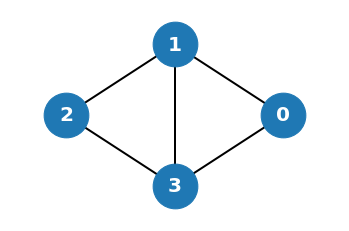

In [3]:
# n is the number of vertices in the graph G, which is also the number of qubits
n = 4
G = nx.Graph()
V = range(n)
G.add_nodes_from(V)
E = [(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)]
G.add_edges_from(E)

# Print out the generated graph G
pos = nx.circular_layout(G)
options = {
    "with_labels": True,
    "font_size": 20,
    "font_weight": "bold",
    "font_color": "white",
    "node_size": 2000,
    "width": 2
}
nx.draw_networkx(G, pos, **options)
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

### Encoding Hamiltonian

In Paddle Quantum, a Hamiltonian can be input in the form of `list`. Here we construct the Hamiltonian $H_D$ in equation (11).

In [4]:
# Construct the Hamiltonian H_D in the form of list
H_D_list = []
for (u, v) in E:
    H_D_list.append([-1.0,'z'+str(u) +',z' + str(v)])
print(H_D_list)

[[-1.0, 'z0,z1'], [-1.0, 'z1,z2'], [-1.0, 'z2,z3'], [-1.0, 'z3,z0'], [-1.0, 'z1,z3']]


As you can see, in this example, the Hamiltonian $H_D$ is

$$
H_D = -Z_0Z_1-Z_1Z_2-Z_2Z_3-Z_3Z_0-Z_1Z_3.
\tag{12}
$$

We can view the matrix form of the Hamiltonian $H_D$ and get information of its eigenvalues:

In [5]:
# Convert Hamiltonian H_D from list form to matrix form
H_D_matrix = pauli_str_to_matrix(H_D_list, n)
# Take out the elements on the diagonal of H_D
H_D_diag = np.diag(H_D_matrix).real
# Get the maximum eigenvalue of H_D
H_max = np.max(H_D_diag)

print(H_D_diag)
print('H_max:', H_max)

[-5.  1. -1.  1.  1.  3.  1. -1. -1.  1.  3.  1.  1. -1.  1. -5.]
H_max: 3.0


### Building the QAOA circuit

Earlier we introduced that QAOA needs to apply two unitary transformations $U_C(\gamma)$ and $U_B(\beta)$ alternately on the initial state $|s\rangle = |+\rangle^{\otimes n}$. Here, we use the quantum gates and quantum circuit templates provided in Paddle Quantum to build a quantum circuit to achieve this step. It should be noted that in the Max-Cut Problem, we simplify the problem of maximizing the expected value of the Hamiltonian $H_C$ to the problem of maximizing the expected value of the Hamiltonian $H_D$, so the unitary transformations to be used are $U_D(\gamma)$ and $U_B(\beta)$. By alternately placing two circuit modules with adjustable parameters, we are able to build a QAOA circuit

$$
U_B(\beta_p)U_D(\gamma_p)\cdots U_B(\beta_1)U_D(\gamma_1),
\tag{13}
$$

where $U_D(\gamma) = e^{-i\gamma H_D}$ can be constructed with the circuit in the figure below. Another unitary transformation $U_B(\beta)$ is equivalent to applying a $R_x$ gate to each qubit.

![U_D circuit](figures/maxcut-fig-cir_ud.png "Figure 3: Quantum circuit of unitary transformation $e^{i\gamma Z\otimes Z}$")
<div style="text-align:center">Figure 3: Quantum circuit of unitary transformation $e^{i\gamma Z\otimes Z}$</div>

Therefore, the quantum circuit that realizes a layer of unitary transformation $U_B(\beta)U_D(\gamma)$ is shown in Figure 4.

![U_BU_D circuit](figures/maxcut-fig-cir_ubud.png "Figure 4: Quantum circuit of unitary transformation $U_B(\beta)U_D(\gamma)$")
<div style="text-align:center">Figure 4: Quantum circuit of unitary transformation $U_B(\beta)U_D(\gamma)$  </div>

In Paddle Quantum, the default initial state of each qubit is $|0\rangle$ (the initial state can be customized by input parameters). We can add a layer of Hadamard gates to change the state of each qubit from $|0\rangle$ to $|+\rangle$ so that we get the initial state $|s\rangle = |+\rangle^{\otimes n}$ required by QAOA. In Paddle Quantum, we can add a layer of Hadamard gates to the quantum circuit by calling `superposition_layer()`.

In [6]:
def circuit_QAOA(num_qubits, depth, edges, vertices):
    # Initialize the quantum circuit of n qubits
    cir = Circuit(num_qubits)
    # Prepare quantum state |s>
    cir.superposition_layer()
    # Build a circuit with p layers of U_D
    cir.qaoa_layer(edges, vertices, depth)
    
    return cir


After running the constructed QAOA quantum circuit, we obtain the output state

$$
|\vec{\gamma},\vec{\beta}\rangle = U_B(\beta_p)U_D(\gamma_p)\cdots U_B(\beta_1)U_D(\gamma_1)|s\rangle.
\tag{14}
$$

### Calculating the loss function

From the output state of the circuit built in the previous step, we can calculate the objective function of the maximum cut problem

$$
F_p(\vec{\gamma},\vec{\beta}) = \langle\vec{\gamma},\vec{\beta}|H_D|\vec{\gamma},\vec{\beta}\rangle.
\tag{15}
$$

To maximize the objective function is equivalent to minimizing $-F_p$. Therefore, we define $L(\vec{\gamma},\vec{\beta}) = -F_p(\vec{\gamma},\vec{\beta})$ as the loss function, that is, the function to be minimized. Then, we use a classical optimization algorithm to find the optimal parameters $\vec{\gamma},\vec{\beta}$. The following code shows the loss function constructed with Paddle Quantum:

In [7]:
# construct the loss function
loss_func = ExpecVal(Hamiltonian(H_D_list))

### Training quantum neural network

After defining the quantum neural network for QAOA, we use the gradient descent method to update the parameters in the network to maximize the expected value in equation (15).

In [8]:
depth = 4      # Number of layers in the quantum circuit
ITR = 120  # Number of training iterations
LR = 0.1   # Learning rate of the optimization method based on gradient descent
SEED = 1024 # Set global RNG seed 

Here, we optimize the loss function defined above in PaddlePaddle.

In [9]:
paddle.seed(SEED)

cir = circuit_QAOA(n, depth, E, V)
# Use Adam optimizer
opt = paddle.optimizer.Adam(learning_rate=LR, parameters=cir.parameters())

for itr in range(1, ITR + 1):
    state = cir()
    # Calculate the gradient and optimize
    loss = -loss_func(state)
    loss.backward()
    opt.minimize(loss)
    opt.clear_grad()
    if itr % 10 == 0:
        print("iter:", itr, "  loss:", "%.4f" % loss.numpy())


iter: 10   loss: -2.5212
iter: 20   loss: -2.7688
iter: 30   loss: -2.9486
iter: 40   loss: -2.9832
iter: 50   loss: -2.9907
iter: 60   loss: -2.9969
iter: 70   loss: -2.9990
iter: 80   loss: -2.9997
iter: 90   loss: -2.9999
iter: 100   loss: -3.0000
iter: 110   loss: -3.0000
iter: 120   loss: -3.0000


### Decoding the quantum solution

After obtaining the minimum value of the loss function and the corresponding set of parameters $\vec{\gamma}^*,\vec{\beta}^*$, our task has not been completed. In order to obtain an approximate solution to the Max-Cut Problem, it is necessary to decode the solution to the classical optimization problem from the quantum state $|\vec{\gamma}^*,\vec{\beta}^*\rangle$ output by QAOA. Physically, to decode a quantum state, we need to measure it and then calculate the probability distribution of the measurement results:

$$
p(z)=|\langle z|\vec{\gamma}^*,\vec{\beta}^*\rangle|^2.
\tag{16}
$$

Usually, the greater the probability of a certain bit string, the greater the probability that it corresponds to an optimal solution of the Max-Cut problem.

Paddle Quantum provides a function to view the probability distribution of the measurement results of the state output by the QAOA quantum circuit:

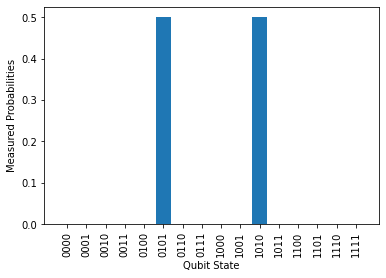

In [10]:
state = cir()
# Repeat the simulated measurement of the circuit output state 1024 times
prob_measure = state.measure(plot=True)

After measurement, we can find the bit string with the highest probability of occurrence. Let the vertices whose bit values are $0$ in the bit string belong to the set $S_0$ and the vertices whose bit values are $1$ belong to the set $S_1$. The set of edges between these two vertex sets is a possible maximum cut of the graph.

The following code selects the bit string with the greatest chance of appearing in the measurement result, then maps it back to the classic solution, and draws the corresponding maximum cut:
- The red vertex belongs to the set $S_0$,
- The blue vertex belongs to the set $S_1$,
- The dashed line indicates the edge being cut.

The bit string form of the cut found: 0101


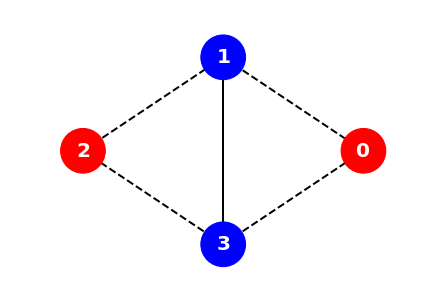

In [11]:
# Find the most frequent bit string in the measurement results
cut_bitstring = max(prob_measure, key=prob_measure.get)
print("The bit string form of the cut found:", cut_bitstring)

# Draw the cut corresponding to the bit string obtained above on the graph
node_cut = ["blue" if cut_bitstring[v] == "1" else "red" for v in V]

edge_cut = []
for u in range(n):
    for v in range(u + 1, n):
        if (u, v) in E or (v, u) in E:
            if cut_bitstring[u] == cut_bitstring[v]:
                edge_cut.append("solid")
            else:
                edge_cut.append("dashed")
nx.draw(G, pos, node_color=node_cut, style=edge_cut, **options)
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()


As you can see, in this example, QAOA has found a maximum cut on the graph.

_______

## References

[1] Farhi, E., Goldstone, J. & Gutmann, S. A Quantum Approximate Optimization Algorithm. [arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)